In [1]:
#@title CLIP preprocess and Imports
!pip -q install ftfy regex tqdm
!pip -q install git+https://github.com/openai/CLIP.git
#!pip -q install tensorflow_addons torchmetrics
import os
import numpy as np
import h5py
import torch
import clip
import cv2
from PIL import Image
from IPython.display import Image as ImagePy, display
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, preprocess = clip.load("RN101")
dataset_path = "/content/data.h5"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 568.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 18.8 MB/s eta 0:00:00
Mounted at /content/drive


100%|███████████████████████████████████████| 278M/278M [00:03<00:00, 80.1MiB/s]


In [2]:
!cp "/content/drive/MyDrive/TESI/CODICE/Columbia Dataset/Frames_labels_dataset/frames_dataset.h5" "/content/data.h5"

In [3]:
people_list = [#"bell",
               "sick",
               "long",
               "bollinger",
               "lieberman",
               ]

In [4]:
#@title Get Indices
from sklearn.model_selection import train_test_split
train_val_indices = {}
with h5py.File(dataset_path, 'r') as f:
    for p in people_list:
      person = f[p]
      indices = person['frames'].attrs.get("data_length")
      train_indices, val_indices = train_test_split(np.arange(indices), test_size=0.2, random_state=42)
      train_val_indices[person.name.lstrip('/')] = (train_indices, val_indices)

In [5]:
#@title Check Chosen People Data
print("----------------------- TRAIN DATA ---- VAL DATA --- TOTAL DATA")
with h5py.File(dataset_path, 'r') as f:
    tot_train = 0
    tot_val = 0
    for p in people_list:
      person = f[p]
      total = person['frames'].attrs.get('data_length')

      train_size = len(train_val_indices[p][0])
      val_size = len(train_val_indices[p][1])

      tot_train += train_size
      tot_val += val_size
      print(f'Group {p}:      \t{train_size} \t\t{val_size} \t\t{total}')

    print(f"TOTAL DATA------------- {tot_train} --------- {tot_val} ---------- {tot_train+tot_val}")

----------------------- TRAIN DATA ---- VAL DATA --- TOTAL DATA
Group sick:      	30820 		7706 		38526
Group long:      	23512 		5879 		29391
Group bollinger:      	12064 		3016 		15080
Group lieberman:      	13120 		3280 		16400
TOTAL DATA------------- 79516 --------- 19881 ---------- 99397


In [6]:
#@title Get Class Weights

class_counts = {}

# Open the HDF5 file
with h5py.File(dataset_path, 'r') as f:
    # Iterate over each group (person) in the file
    for p in people_list:
        person = f[p]
        labels = []
        for index in train_val_indices[p][0]:
          labels.append(person['labels'][index])
        # Count occurrences of each class in the labels
        for label in labels:
            class_counts[label] = class_counts.get(label, 0) + 1

# Calculate total number of training samples
total_train_samples = sum(class_counts.values())

# Compute class weights as the inverse of class frequencies
class_weights = {cls: total_train_samples / count for cls, count in class_counts.items()}

# Normalize the weights so that they sum up to 1 (optional)
total_weight = sum(class_weights.values())
class_weights_normalized = {cls: weight / total_weight for cls, weight in class_weights.items()}
print(class_weights_normalized)
# Convert class weights to a tensor
class_weights_tensor = torch.tensor(list(class_weights_normalized.values()), dtype=torch.float)
positive_class_weight_tensor = class_weights_tensor[1].clone().detach().cuda()

{0: 0.37242819055284476, 1: 0.6275718094471554}


In [ ]:
#@title Data Generator
class FineTuneDataGenerator:
    def __init__(self, data_directory, batch_size, preprocess_f, speakers, mode):
        self.data_directory = data_directory
        self.batch_size = batch_size
        self.speakers = speakers
        self.mode = mode  # 'train' or 'validation'
        self.preprocess = preprocess_f

    def __iter__(self):
        with h5py.File(self.data_directory, 'r') as h5_file:
            for speaker in self.speakers:
                frames_dataset = h5_file[speaker]['frames']
                labels_dataset = h5_file[speaker]['labels']
                data_length = frames_dataset.attrs['data_length']
                train_split_index = frames_dataset.attrs['train_split_index']

                # Determine the indices for training or validation split
                if self.mode == 'train':
                    indices = np.arange(train_split_index)
                else:
                    indices = np.arange(train_split_index, data_length)

                np.random.shuffle(indices)

                # Yield batches
                for i in range(0, len(indices), self.batch_size):
                    batch_indices = indices[i:i + self.batch_size]
                    batch_indices = np.sort(batch_indices)

                    frames = []
                    for index in batch_indices:

                      f = Image.fromarray(frames_dataset[index])
                      f = f.convert('RGB') if f.mode != 'RGB' else f
                      f = preprocess(f)
                      frames.append(f)

                    labels = labels_dataset[batch_indices]
                    yield torch.stack(frames), np.array(labels)

In [7]:
#@title Data Loader con miglior shuffle tra Speakers
class FineTuneDataGenerator:
    def __init__(self, data_directory, batch_size, preprocess_f, indices, mode):
        self.data_directory = data_directory
        self.batch_size = batch_size
        self.preprocess = preprocess_f
        self.groups = list(indices.keys())
        self.mode = mode  # 'train' or 'validation'
        self.indices_dict = indices

        self.h5_file = h5py.File(self.data_directory, 'r')
        group_data = []
        for group in self.groups:
              frames_dataset = self.h5_file[group]['frames']
              labels_dataset = self.h5_file[group]['labels']

              if self.mode == 'train':
                group_data.append((frames_dataset, labels_dataset, self.indices_dict[group][0]))
              else:
                group_data.append((frames_dataset, labels_dataset, self.indices_dict[group][1]))

        self.group_data = group_data

    def close_file(self):
      self.h5_file.close()

    def shuffle_replenish_data(self):
        # print("\nBefore Shuffle:")
        # for frames_dataset, labels_dataset, indices in self.group_data:
        #   print(f"\t lunghezza indici:{len(indices)}")

        self.group_data.clear() # resetta la lista di gruppi USATI

        for group in self.groups:
              frames_dataset = self.h5_file[group]['frames']
              labels_dataset = self.h5_file[group]['labels']

              if self.mode == 'train':
                shuffled_indices = np.random.permutation(self.indices_dict[group][0])
                self.group_data.append((frames_dataset, labels_dataset, shuffled_indices))
              else:
                shuffled_indices = np.random.permutation(self.indices_dict[group][1])
                self.group_data.append((frames_dataset, labels_dataset, shuffled_indices))

        # print("\nAfter shuffle: ")
        # for frames_dataset, labels_dataset, indices in self.group_data:
        #   print(f"\t lunghezza indici:{len(indices)}")


    def __len__(self):
        length = 0
        for group in self.group_data:
          length += len(group[2])

        return length // self.batch_size

    def __iter__(self):

            batch_frames = []
            batch_labels = []

            # Calculate the number of data points to take from each group per batch
            data_per_group = self.batch_size // len(self.groups)

            if self.mode == 'train':
              # Interleave data from different groups
              while any(len(data[2]) for data in self.group_data):
                  for _ in range(data_per_group):
                      for i, (frames_dataset, labels_dataset, indices) in enumerate(self.group_data):
                          if len(indices):
                              index = indices[0]
                              self.group_data[i] = (frames_dataset, labels_dataset, indices[1:])  # Update the indices in group_data
                              frame = frames_dataset[index]
                              label = labels_dataset[index]
                              f = Image.fromarray(frame)
                              f = f.convert('RGB') if f.mode != 'RGB' else f
                              batch_frames.append(self.preprocess(f))
                              #batch_frames.append(torch.from_numpy(frame))
                              batch_labels.append(label)

                              # Check if the batch is complete
                              if len(batch_frames) == self.batch_size:
                                  # Yield the batch and reset the containers
                                  yield torch.stack(batch_frames), torch.tensor(batch_labels)

                                  batch_frames = []
                                  batch_labels = []

              # Yield any remaining data as the last batch
              if batch_frames:
                  yield torch.stack(batch_frames), torch.tensor(batch_labels)

            else: # 'validation', no interleaving between groups
              for frames_dataset, labels_dataset, indices in self.group_data:
                  for index in indices:
                      frame = frames_dataset[index]
                      label = labels_dataset[index]
                      f = Image.fromarray(frame)
                      f = f.convert('RGB') if f.mode != 'RGB' else f
                      batch_frames.append(self.preprocess(f))
                      batch_labels.append(label)

                      if len(batch_frames) == self.batch_size:
                          # Yield the batch and reset the containers
                          yield torch.stack(batch_frames), torch.tensor(batch_labels)
                          batch_frames = []
                          batch_labels = []

              # Yield any remaining data as the last batch
              if batch_frames:
                  yield torch.stack(batch_frames), torch.tensor(batch_labels)


In [ ]:
#@title Custom Dataset

from torch.utils.data import Dataset

def worker_init_fn(worker_id):
    global h5_file
    h5_file = h5py.File(dataset_path, 'r')

class FineTuneDataset(Dataset):
    def __init__(self, data_directory, preprocess_f, speakers, mode):
        self.data_directory = data_directory
        self.preprocess = preprocess_f
        self.groups = speakers
        self.mode = mode  # 'train' or 'validation'
        self.h5_file = h5py.File(self.data_directory, 'r')  # Open the HDF5 file
        self.length = 0  # Initialize the length of the dataset
        self.indices = []  # Initialize the list of indices for each group
        for group in self.groups:
            frames_dataset = self.h5_file[group]['frames']
            labels_dataset = self.h5_file[group]['labels']
            data_length = frames_dataset.attrs['data_length']
            train_split_index = frames_dataset.attrs['train_split_index']

            # Determine the indices for training or validation split
            if self.mode == 'train':
                indices = np.arange(train_split_index)
                self.length += train_split_index
            else:
                indices = np.arange(train_split_index, data_length)
                self.length += (data_length - train_split_index)

            # Shuffle indices within each group
            np.random.shuffle(indices)
            self.indices.append(indices)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Find the group and the index within the group for the given idx
        group_idx = 0
        group_length = len(self.indices[0])
        while idx >= group_length:
            idx -= group_length
            group_idx += 1
            group_length = len(self.indices[group_idx])

        # Get the frame and label datasets for the group
        group = self.groups[group_idx]
        frames_dataset = self.h5_file[group]['frames']
        labels_dataset = self.h5_file[group]['labels']

        # Get the frame and label for the index within the group
        index = self.indices[group_idx][idx]
        frame = frames_dataset[index]
        label = labels_dataset[index]

        # Convert the frame to a PIL image and apply the preprocessing function
        f = Image.fromarray(frame)
        f = f.convert('RGB') if f.mode != 'RGB' else f
        frame = self.preprocess(f)

        # Return the frame and label as tensors
        return frame, label


In [ ]:
#@title Custom Dataset con Sampler
from torch.utils.data import Dataset, DataLoader, Sampler
class FineTuneDataset2(Dataset):
    def __init__(self, data_directory, preprocess_f, speakers, mode):
        self.data_directory = data_directory
        self.preprocess = preprocess_f
        self.groups = speakers
        self.mode = mode  # 'train' or 'validation'
        self.h5_file = h5py.File(self.data_directory, 'r')  # Open the HDF5 file
        self.indices = []  # Initialize the list of indices for each group
        self.group_lengths = []  # Initialize the list of lengths for each group
        for group in self.groups:
            frames_dataset = self.h5_file[group]['frames']
            labels_dataset = self.h5_file[group]['labels']
            data_length = frames_dataset.attrs['data_length']
            train_split_index = frames_dataset.attrs['train_split_index']

            # Determine the indices for training or validation split
            if self.mode == 'train':
                indices = np.arange(train_split_index)
            else:
                indices = np.arange(train_split_index, data_length)

            # Shuffle indices within each group
            np.random.shuffle(indices)
            self.indices.append(indices)
            self.group_lengths.append(len(indices))

    def __len__(self):
        return sum(self.group_lengths)

    def __getitem__(self, idx):
        # Find the group and the index within the group for the given idx
        group_idx = 0
        while idx >= self.group_lengths[group_idx]:
            idx -= self.group_lengths[group_idx]
            group_idx += 1

        # Get the frame and label datasets for the group
        group = self.groups[group_idx]
        frames_dataset = self.h5_file[group]['frames']
        labels_dataset = self.h5_file[group]['labels']

        # Get the frame and label for the index within the group
        index = self.indices[group_idx][idx]
        frame = frames_dataset[index]
        label = labels_dataset[index]

        # Convert the frame to a PIL image and apply the preprocessing function
        f = Image.fromarray(frame)
        f = f.convert('RGB') if f.mode != 'RGB' else f
        frame = self.preprocess(f)

        # Return the frame and label as tensors
        return frame, label

class InterleavedBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        batch = []
        group_indices = [list(indices) for indices in self.dataset.indices]
        group_order = list(range(len(self.dataset.groups)))  # Order in which groups are accessed

        while any(group_indices):
            for group_idx in group_order:
                indices = group_indices[group_idx]
                if indices:
                    batch.append(indices.pop(0))
                    if len(batch) == self.batch_size:
                        yield batch
                        batch = []
        if batch:
            yield batch

    def __len__(self):
        return len(self.dataset)

In [ ]:
#@title TEST GENERATOR
# generator semplice:             0.28 sec
# generator con miglior shuffle:  0.39 sec
import time

data_generator = FineTuneDataGenerator(dataset_path, 64, preprocess, ['bell', 'sick', 'long', 'bollinger'], 'train')

# Generate one batch of data
try:
    start = time.time()
    frames, labels = next(iter(data_generator))
    end = time.time()
    labels = labels.unsqueeze(1)
    print(f"Batch generated successfully in time: {end-start}")
    print("Frames shape:", frames.shape)
    print("Labels shape:", labels.shape)
except StopIteration:
    print("No more data to generate.")

Batch generated successfully in time: 0.2429492473602295
Frames shape: torch.Size([64, 3, 224, 224])
Labels shape: torch.Size([64, 1])


tensor([0], dtype=torch.uint8)


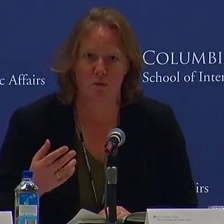

In [ ]:
import cv2

unnormalize = transforms.Normalize((-0.48145466/0.26862954, -0.4578275/0.26130258, -0.40821073/0.27577711), (1/0.26862954, 1/0.26130258, 1/0.27577711))
img = transforms.ToPILImage()(unnormalize(frames[4])).convert("RGB")
img = np.array(img)
cv2.imwrite('test.jpg', img)
print(labels[2])
display(ImagePy('test.jpg'))

In [8]:
#@title Custom Clip Model
class CustomCLIP(torch.nn.Module):
  def __init__(self):
    super().__init__()
    model = clip_model

    # modal.visual: prendere il codificatore visuale di CLIP (visual encoder of CLIP)
    # float: l'encoder è convertito a 32 bit poiché il CLIP predefinito è a 16 bit
    self.encoder = model.visual.float()

    # aggiunge uno strato lineare (add a single linear layer)
    self.classifier = torch.nn.Linear(512, 1)

  # Il simbolo -> viene utilizzato per specificare il tipo di valore restituito dalla funzione
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.encoder(x)
    x = self.classifier(x)

    return x

net = CustomCLIP().to(device)

trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {trainable_params}')

Number of trainable parameters: 56260449


In [12]:
net.load_state_dict(torch.load("/content/drive/MyDrive/TESI/CODICE/CLIP_Models/ResNet_5_epochs_no_bell.pth"))

<All keys matched successfully>

In [13]:
#@title Training & Test Steps
from tqdm import tqdm
def training_step(net, data_loader, optimizer, cost_function, device='cuda'):
    samples = 0.0
    cumulative_loss = 0.0
    cumulative_accuracy = 0.0

    # Set the network to training mode
    net.train()

    # Iterate over the training set
    for batch_idx, (frames, labels) in enumerate(tqdm(data_loader, desc="Train Progress")):
        frames = frames.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        # Forward pass
        outputs = net(frames)

        # Loss computation
        loss = cost_function(outputs, labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        samples += frames.shape[0]
        cumulative_loss += loss.item()
        #_, predicted = outputs.max(1)

        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > 0.5).float()

        # Compute training accuracy
        cumulative_accuracy += predictions.eq(labels).sum().item()

    if samples==0: print("ZERO SAMPLES GENERATED in train!!!")
    return cumulative_loss / samples, cumulative_accuracy / samples

def test_step(net, data_loader, cost_function, device='cuda'):
    samples = 0.0
    cumulative_loss = 0.0
    cumulative_accuracy = 0.0

    # Set the network to evaluation mode
    net.eval()

    with torch.no_grad():
        # Iterate over the test set
        for batch_idx, (frames, labels) in enumerate(tqdm(data_loader, desc="Eval Progress")):
            frames = frames.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            # Forward pass
            outputs = net(frames)

            # Loss computation
            loss = cost_function(outputs, labels)

            samples += frames.shape[0]
            cumulative_loss += loss.item()
            #_, predicted = outputs.max(1)

            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()

            # Compute test accuracy
            cumulative_accuracy += predictions.eq(labels).sum().item()

    if samples==0: print("ZERO SAMPLES GENERATED in val!!!")
    return cumulative_loss / samples, cumulative_accuracy / samples


In [ ]:
#@title TEST 1 TRAINING EPOCH

mode = "train"
data_loader = FineTuneDataGenerator(dataset_path, 64, preprocess, people_list, mode)
# custom_dataset = FineTuneDataset(dataset_path, preprocess, people_list, 'train')
# data_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=64, shuffle=True,
#                                           num_workers=2, worker_init_fn=worker_init_fn, pin_memory=True)

optimizer = torch.optim.Adam(net.parameters(), lr=args['learning_rate'])
cost_function = torch.nn.BCEWithLogitsLoss(pos_weight=positive_class_weight_tensor)

loss, accuracy = training_step(net, data_loader, optimizer, cost_function, device='cuda')

# Print the results
print(f"Average loss: {loss:.4f}, Average accuracy: {accuracy:.2f}%")

In [14]:
args = {
      'batch_size':32,
      'device':'cuda:0',
      'learning_rate':0.001,
      'weight_decay':0.0005, # L2 Regularization, aumento se overfitta
      'momentum':0.9,
      'epochs':5,
      'people_list':people_list,
      'class_weight':positive_class_weight_tensor,
      'indices': train_val_indices
    }

# se vedo che la LOSS cambia troppo poco --> aumento Learning Rate (e viceversa se ondeggia troppo)

In [15]:
!pip -q install wandb
import wandb
!wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [16]:
wandb.init(
    # set the wandb project where this run will be logged
    project="CLIP ResNet101 Finetuning",
    name="2 - no Bell bs=32",

    # track hyperparameters and run metadata
    config={
    "learning_rate": args['learning_rate'],
    "epochs": args['epochs'],
    "batch_size":args['batch_size'],
    'weight_decay':args["weight_decay"]

    }
)

wandb: Currently logged in as: a-appiani2 (andrea-unibg). Use `wandb login --relogin` to force relogin


In [17]:
#@title MAIN FUNCTION
def main(
      batch_size,
      device,
      learning_rate,
      weight_decay,
      momentum,
      epochs,
      people_list,
      class_weight,
      indices
    ):
  print(f"Persone viste in training: {people_list}")

  train_generator = FineTuneDataGenerator(dataset_path, batch_size, preprocess, indices, mode="train")
  val_generator = FineTuneDataGenerator(dataset_path, batch_size, preprocess, indices, mode="val")

  optimizer = torch.optim.Adam(net.parameters(), lr=args['learning_rate'], weight_decay = weight_decay)
  cost_function = torch.nn.BCEWithLogitsLoss(pos_weight=class_weight)

  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1) #ogni 3 epoche riduce LR di un fattore 10

  for e in range(epochs):

    train_loss, train_accuracy = training_step(net, train_generator, optimizer, cost_function)
    val_loss, val_accuracy = test_step(net, val_generator, cost_function)

    train_generator.shuffle_replenish_data()

    #scheduler.step()

    wandb.log({"Training Loss": train_loss, "Training Accuracy": train_accuracy, "Validation Loss": val_loss, "Validation Accuracy": val_accuracy})

    print('Epoch: {:d}'.format(e+1))
    print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  train_generator.close_file()
  val_generator.close_file()
  wandb.finish()

In [ ]:
main(**args)

Persone viste in training: ['sick', 'long', 'bollinger', 'lieberman']


Train Progress: 2485it [27:55,  1.48it/s]
Eval Progress: 622it [02:55,  3.55it/s]


Epoch: 1
	Training loss 0.00106, Training accuracy 0.99
	Validation loss 0.00674, Validation accuracy 0.92
-----------------------------------------------------


Train Progress: 2485it [27:35,  1.50it/s]
Eval Progress: 622it [02:57,  3.51it/s]                         


Epoch: 2
	Training loss 0.00097, Training accuracy 0.99
	Validation loss 0.00420, Validation accuracy 0.93
-----------------------------------------------------


Train Progress: 2485it [27:47,  1.49it/s]
Eval Progress: 622it [02:58,  3.49it/s]                         


Epoch: 3
	Training loss 0.00093, Training accuracy 0.99
	Validation loss 0.00369, Validation accuracy 0.95
-----------------------------------------------------


Train Progress: 2485it [27:46,  1.49it/s]
Eval Progress: 622it [02:59,  3.46it/s]                         


Epoch: 4
	Training loss 0.00087, Training accuracy 0.99
	Validation loss 0.00368, Validation accuracy 0.94
-----------------------------------------------------


Train Progress:  74%|███████▎  | 1830/2484 [20:34<07:22,  1.48it/s]

In [ ]:
# Save the model's state_dict
torch.save(net.state_dict(), '/content/drive/MyDrive/TESI/CODICE/CLIP_Models/ResNet_10_epochs_no_bell.pth')

## Usare il modello finetunato

In [ ]:
import torch

# Assuming your CustomCLIP model is already fine-tuned
fine_tuned_model = CustomCLIP(num_classes=2)

# Load the trained weights
fine_tuned_model.load_state_dict(torch.load("path/to/your/fine_tuned_model.pth"))

# Set the model to evaluation mode
fine_tuned_model.eval()

# Assuming 'frames' is a batch of frames that you want to get embeddings for
with torch.no_grad():
    # Extract embeddings using the CLIP Visual Encoder
    embeddings = fine_tuned_model.image_encoder(frames)

